In [28]:
from pathlib import Path

import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr

In [29]:
auth = earthaccess.login(persist=True)
fs = earthaccess.get_fsspec_https_session()

In [30]:
# 2. Get Level-3 Data

OB_DAAC_PROVISIONAL = "https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/"
HARP2_L3_MAPOL_FILENAME = "PACE_HARP2.20240306.L3m.DAY.CLOUD_GPC.V3_0.1deg.nc"
fs.get(f"{OB_DAAC_PROVISIONAL}/{HARP2_L3_MAPOL_FILENAME}", "data/")
paths = list(Path("data").glob("*.nc"))
paths

[PosixPath('data/PACE_HARP2.20240306.L3m.DAY.CLOUD_GPC.V3_0.1deg.nc')]

In [31]:


datatree = xr.open_datatree(paths[0])

datatree

<xarray.DataTree>
Group: /
│   Dimensions:                               (lat: 180, lon: 360)
│   Coordinates:
│     * lat                                   (lat) float32 720B 89.5 88.5 ... -89.5
│     * lon                                   (lon) float32 1kB -179.5 ... 179.5
│   Data variables:
│       cloud_bow_droplet_effective_radius    (lat, lon) float32 259kB ...
│       cloud_bow_droplet_effective_variance  (lat, lon) float32 259kB ...
│       cloud_bow_rms                         (lat, lon) float32 259kB ...
│       cloud_bow_fit_correlation             (lat, lon) float32 259kB ...
│       cloud_rft_mode_fraction_0             (lat, lon) float32 259kB ...
│       cloud_rft_mode_fraction_1             (lat, lon) float32 259kB ...
│       cloud_liquid_index                    (lat, lon) float32 259kB ...
│   Attributes: (12/54)
│       product_name:                      PACE_HARP2.20240306.L3m.DAY.CLOUD_GPC....
│       instrument:                        HARP2
│       title:                             HARP2 Level-3 Standard Mapped Image
│       project:                           Ocean Biology Processing Group (NASA/G...
│       platform:                          PACE
│       source:                            satellite observations from HARP2-PACE
│       ...                                ...
│       keywords:                          
│       id:                                L3/PACE_HARP2.20240306.L3m.DAY.CLOUD_G...
│       history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
│       processing_version:                3.0
│       identifier_product_doi_authority:  https://dx.doi.org
│       identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0
└── Group: /processing_control
    │   Attributes:
    │       l3map_files:       PACE_HARP2.20240306.L3m.DAY.CLDBOW_GPC.V3_0.1deg.nc,PA...
    │       software_name:     l3mapmerge
    │       software_version:  1.2
    └── Group: /processing_control/input_parameters
            Attributes:
                doi:       
                pversion:  
                ifile:     l3mapmerge_inputs.txt
                ofile:     PACE_HARP2.20240306.L3m.DAY.CLOUD_GPC.V3_0.1deg.nc
                product:   cloud_bow_droplet_effective_radius,cloud_bow_droplet_effective...

In [32]:
dataset = xr.merge(datatree.to_dict().values())
dataset

<xarray.Dataset> Size: 2MB
Dimensions:                               (lat: 180, lon: 360)
Coordinates:
  * lat                                   (lat) float32 720B 89.5 88.5 ... -89.5
  * lon                                   (lon) float32 1kB -179.5 ... 179.5
Data variables:
    cloud_bow_droplet_effective_radius    (lat, lon) float32 259kB ...
    cloud_bow_droplet_effective_variance  (lat, lon) float32 259kB ...
    cloud_bow_rms                         (lat, lon) float32 259kB ...
    cloud_bow_fit_correlation             (lat, lon) float32 259kB ...
    cloud_rft_mode_fraction_0             (lat, lon) float32 259kB ...
    cloud_rft_mode_fraction_1             (lat, lon) float32 259kB ...
    cloud_liquid_index                    (lat, lon) float32 259kB ...
Attributes: (12/54)
    product_name:                      PACE_HARP2.20240306.L3m.DAY.CLOUD_GPC....
    instrument:                        HARP2
    title:                             HARP2 Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from HARP2-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_HARP2.20240306.L3m.DAY.CLOUD_G...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0

In [33]:
datatree["cloud_bow_droplet_effective_radius"]

<xarray.DataArray 'cloud_bow_droplet_effective_radius' (lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      Cloud droplet effective radius obtained using Cloud Bow.
    valid_min:      3.0
    valid_max:      53.4
    display_scale:  linear
    display_min:    3.0
    display_max:    53.4

In [34]:
# 4. Visualize HARP2 L3 products

cbder = dataset["cloud_bow_droplet_effective_radius"].values
cbdev = dataset["cloud_bow_droplet_effective_variance"].values
cli = dataset["cloud_liquid_index"].values
cbder.shape, cbdev.shape, cli.shape


((180, 360), (180, 360), (180, 360))

In [35]:
lat = dataset["lat"].values
lon = dataset["lon"].values
plot_range = [lon.min(), lon.max(), lat.min(), lat.max()]


In [39]:
def plot_l2_product(
    data, plot_range, label, title, vmin, vmax, figsize=(12, 4), cmap="viridis"
):
    """Make map and histogram (default)."""

    # Create a figure with two subplots: 1 for map, 1 for histogram
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    # Map subplot
    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax_map.set_extent(plot_range, crs=ccrs.PlateCarree())
    ax_map.coastlines(resolution="110m", color="black", linewidth=0.8)
    ax_map.gridlines(draw_labels=True)

    # Assume lon and lat are defined globally or passed in
    pm = ax_map.pcolormesh(
        lon, lat, data, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap
    )
    plt.colorbar(pm, ax=ax_map, orientation="vertical", pad=0.1, label=label)
    ax_map.set_title(title, fontsize=12)

    # Histogram subplot
    ax_hist = fig.add_subplot(gs[1])
    flattened_data = data[~np.isnan(data)]  # Remove NaNs for histogram
    #flattened_data = data
    valid_count = np.sum(~np.isnan(flattened_data))
    ax_hist.hist(
        flattened_data, bins=40, color="gray", range=[vmin, vmax], edgecolor="black"
    )
    ax_hist.set_xlabel(label)
    ax_hist.set_ylabel("Count")
    ax_hist.set_title("Histogram: N=" + str(valid_count))


    plt.show()

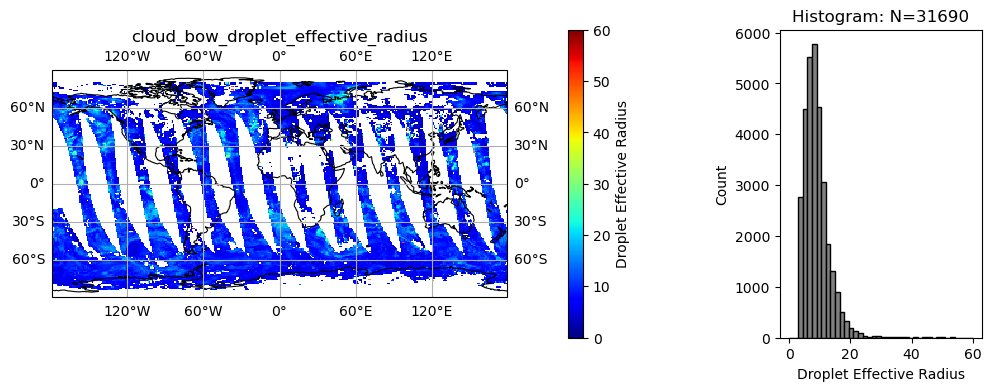

In [40]:

title = "cloud_bow_droplet_effective_radius"

label = "Droplet Effective Radius"
data = cbder[:, :]

plot_l2_product(
    data, plot_range=plot_range, label=label, title=title, vmin=0, vmax=60, cmap="jet"
)


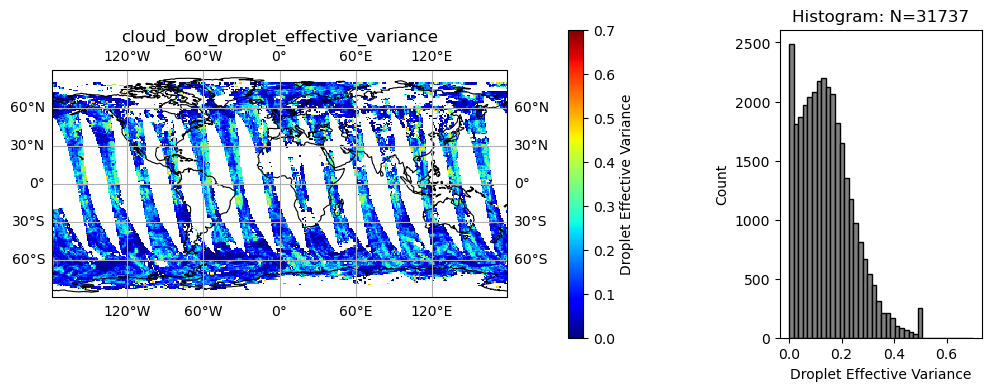

In [41]:
title = "cloud_bow_droplet_effective_variance"

label = "Droplet Effective Variance"
data = cbdev[:, :]

plot_l2_product(
    data, plot_range=plot_range, label=label, title=title, vmin=0, vmax=0.7, cmap="jet"
)

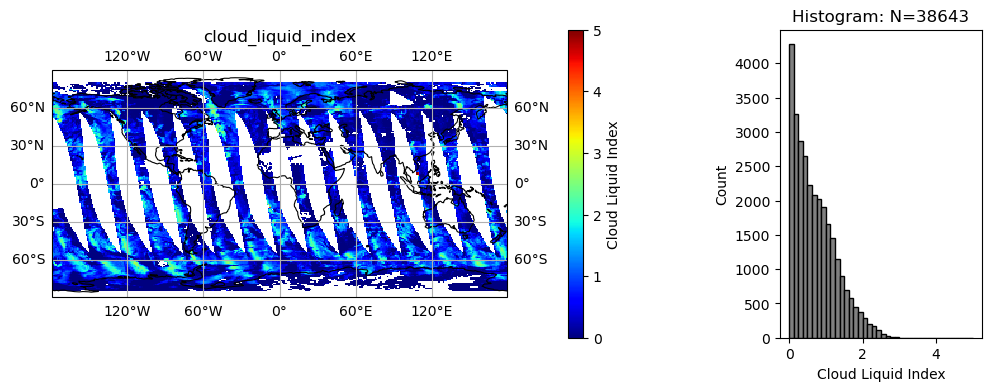

In [42]:
title = "cloud_liquid_index"

label = "Cloud Liquid Index"
data = cli[:, :]

plot_l2_product(
    data, plot_range=plot_range, label=label, title=title, vmin=0, vmax=5, cmap="jet"
)